# 2. Preprocesado

En este apartado se estudiarán las características con valores perdidos y se discriminarán aquellas cuyos valores permiten "NA's" de las que no. Para los valores perdidos reales, se evaluarán diferentes formas de imputación y se ejecutará la que se considere más conveniente.

Por otra parte, se procederá a la conversión de variables categóricas a dummies y a la transformación logarítmica de aquellas variables contínuas que no sigan una distribución normal y no cumplan la hipótesis de homocedasticidad. Por último se tipificarán las variables para conseguir un conjunto de datos lo más homogéneo posible e idóneo para el funcionamiento de los algoritmos.

## Inicialización de Spark y carga de librerías

In [1]:
import sys
import os

spark_path = "/Applications/spark-2.1.0-bin-hadoop2.7"
sys.path.append(spark_path + "/python")
sys.path.append(spark_path + "/python/lib/py4j-0.10.4-src.zip")

from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").appName("Entrega") \
    .getOrCreate()

spark

In [2]:
from pyspark.sql.functions import col, count, mean, sum as agg_sum
from pyspark.sql.functions import lit 
from pyspark.sql.types import IntegerType, DoubleType 
from pyspark.sql.functions import  udf 
from pyspark.mllib.stat import Statistics 
from pyspark.mllib.linalg import Vectors
from pyspark.ml.feature import StringIndexer, IndexToString, VectorAssembler, OneHotEncoder, StandardScaler
from pyspark.ml import Pipeline
from pyspark.sql.functions import log1p, expm1

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Carga  y unión de los datos

In [3]:
train_path = "datos/train.csv"
test_path = "datos/test.csv"

# Por simplicidad, se ha elegido la opción de inferir esquema de los datos
test = spark.read.csv(test_path, header=True, inferSchema=True, nullValue= 'NA')
train = spark.read.csv(train_path, header=True, inferSchema=True,nullValue= 'NA')

# Se crea la columna Sale price para los datos test
test = test.withColumn('SalePrice', lit(None).cast('Integer'))

In [4]:
# Hay que verificar que las columnas siguen el mismo orden y esquema
if train.columns==test.columns:
    # Unión de los datasets
    union = train.union(test)
    print("Las columnas de ambos conjuntos tienen el mismo orden!!")
else:
    print("Error, llos dos conjuntos de datos tienen estructuras diferentes!!")

Las columnas de ambos conjuntos tienen el mismo orden!!


In [5]:
dataset_size = union.count()
print("Número de observaciones conjuntas entre los datos de entrenamiento y test: ", dataset_size)

Número de observaciones conjuntas entre los datos de entrenamiento y test:  2919


## Valores perdidos:

En este apartado analizaremos y discriminaremos los diferentes casos en los que existen valores perdidos. La documentación adjunta en el proyecto indica que hay ciertas variables en los que los valores NA constituyen un valor en sí mismo, y por tanto no deben de considerarse valores perdidos como tal. 

Hay que tener cuidado a la hora de eliminar observaciones completas debido a la existencia de valores perdidos ya que conlleva una reducción del conjunto de datos. Por otra parte, la imputación de valores perdidos también ha de realizarse siguiendo ciertos criterios que eviten sesgar las observaciones.

Vamos a recuperar la gráfica realizada en el notebook 1. Análisis, en la que se observan las variables con mayor número de valores faltantes. 

In [6]:
# Funciones que permiten el cálculo de los valores perdidos por variable
from pyspark.sql.functions import col, count, sum as agg_sum

# Devuelve el agregado de valoes perdidos para cada columna pasada por parámetro
def count_nulls(c):
    return agg_sum(col(c).isNull().cast(IntegerType())).alias(c)

# Devuelve la agregación de todas las columnas
def tmp1(df):
    # Definimos la operación para cada columna del DF.
    exprs = [count_nulls(c) for c in df.columns]
    return df.agg(*exprs).collect()

# El resultado se convierte a diccionario para facilitar el tratamiento
dic_list = tmp1(union)[0].asDict()

# Se filtran aquellas variables sin valores perdidos
dic_filtered = dict((k, v) for (k, v) in dic_list.items() if v > 0)

# Se oredenan en función del número de valores perdidos
temp = sorted(dic_filtered.items(), key=lambda x: x[1], reverse = True)

In [7]:
# Se crean listas que almacenan los valores y etiquetas
var = [var[0] for var in temp if var[0]!= "SalePrice"]
value = [value[1] for value in temp if value[0]!= "SalePrice"]
percent = [(value[1]/dataset_size)*100 for value in temp if value[0]!= "SalePrice"]

print("Se tienen un total de {} variables con valores perdidos".format(len(value)))

Se tienen un total de 34 variables con valores perdidos


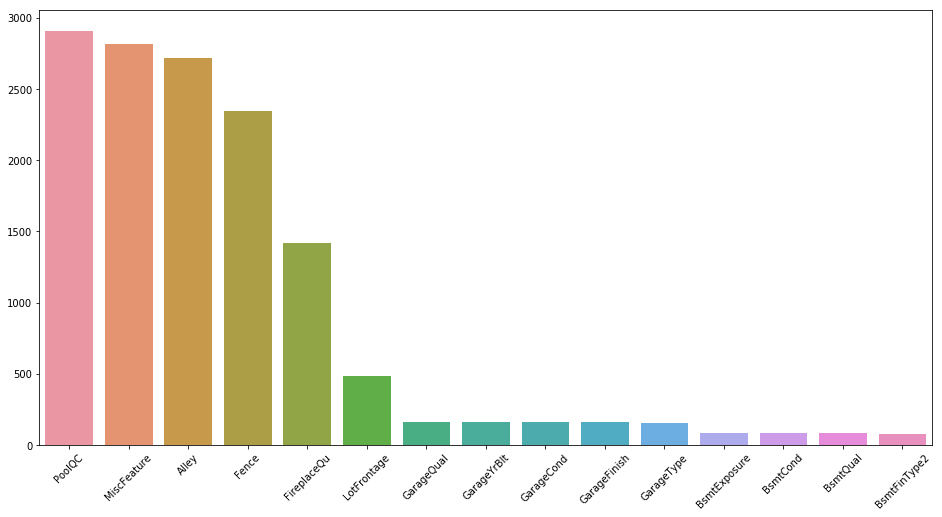

In [8]:
# Por motivos de representación sólo se mostrarán las 15 variables con mayor número de valores perdidos
sns.set_style()
plt.figure(figsize=(16,8))
plt.xticks(rotation=45)
ax = sns.barplot(x=var[:15], y=value[:15])

Hay muchas teorías diferentes en cuanto al máximo porcentaje de valores perdidos en una variable antes de considerar eliminarla. En nuestro caso, se tomará uno de los límites más extendidos, el del 15%. Por tanto, se eliminarán aquellas variables que presenten más del 15% de valores perdidos. Imputar valores a una variable que supere dicho umbral de valores perdidos podría sesgar la muestra e inducir ruido en nuestro dataset.

In [9]:
data ={"Var name": var, "Total":value, "Percent":percent}
con_na = pd.DataFrame(data, columns=[["Var name", "Total", "Percent"]])
con_na.head(25)

,Var name,Total,Percent
0,PoolQC,2909,99.657417
1,MiscFeature,2814,96.402878
2,Alley,2721,93.216855
3,Fence,2348,80.438506
4,FireplaceQu,1420,48.646797
5,LotFrontage,486,16.649538
6,GarageQual,159,5.447071
7,GarageYrBlt,159,5.447071
8,GarageCond,159,5.447071
9,GarageFinish,159,5.447071


Según la consideración anterior, y con la lectura de la tabla, se determina que las variables **PoolQC, MiscFeature, Alley, Fence, FireplaceQu y LotFrontage** han de ser eliminadas. Sin embargo, y tal como se introdujo en el comienzo del ejercicio, muchos de los valores "NA" en estas variables son valores permitidos, por lo que antes de eliminar ninguna variable, hemos de tener en cuenta esta situación.

## Cambio de NA por etiqueta con significado.

In [10]:
# Columnas con NA permitidos:
valid_na_col = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
                'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 
                'Fence', 'MiscFeature']

### Numéricas:

In [11]:
union = union.withColumn('GarageYrBlt_NA', col('GarageYrBlt').isNull().cast('Integer'))
GarageYrBlt_mean = union.agg(mean(col('GarageYrBlt')).alias('media')).collect()[0]['media']
union = union.fillna({'GarageYrBlt':GarageYrBlt_mean})

### Categóricas:

In [12]:
# Se rellenan con cat_NA los valores perdidos en las variables premitidas
tmp_dic ={c:'cat_NA' for c in dic_filtered if c in valid_na_col}
union=union.fillna(tmp_dic)

In [13]:
union.select(valid_na_col[:10]).show(10)

+------+--------+--------+------------+------------+------------+-----------+----------+------------+----------+
| Alley|BsmtQual|BsmtCond|BsmtExposure|BsmtFinType1|BsmtFinType2|FireplaceQu|GarageType|GarageFinish|GarageQual|
+------+--------+--------+------------+------------+------------+-----------+----------+------------+----------+
|cat_NA|      Gd|      TA|          No|         GLQ|         Unf|     cat_NA|    Attchd|         RFn|        TA|
|cat_NA|      Gd|      TA|          Gd|         ALQ|         Unf|         TA|    Attchd|         RFn|        TA|
|cat_NA|      Gd|      TA|          Mn|         GLQ|         Unf|         TA|    Attchd|         RFn|        TA|
|cat_NA|      TA|      Gd|          No|         ALQ|         Unf|         Gd|    Detchd|         Unf|        TA|
|cat_NA|      Gd|      TA|          Av|         GLQ|         Unf|         TA|    Attchd|         RFn|        TA|
|cat_NA|      Gd|      TA|          No|         GLQ|         Unf|     cat_NA|    Attchd|        

### Recálculo de valores perdidos

In [14]:
# El resultado se convierte a diccionario para facilitar el tratamiento
dic_list = tmp1(union)[0].asDict()

# Se filtran aquellas variables sin valores perdidos
dic_filtered = dict((k, v) for (k, v) in dic_list.items() if v > 0)

# Se oredenan en función del número de valores perdidos
temp = sorted(dic_filtered.items(), key=lambda x: x[1], reverse = True)

# Se crean listas que almacenan los valores y etiquetas
var = [var[0] for var in temp if var[0]!= "SalePrice"]
value = [value[1] for value in temp if value[0]!= "SalePrice"]
percent = [(value[1]/dataset_size)*100 for value in temp if value[0]!= "SalePrice"]

print("Se tienen un total de {} variables con valores perdidos".format(len(value)))

Se tienen un total de 19 variables con valores perdidos


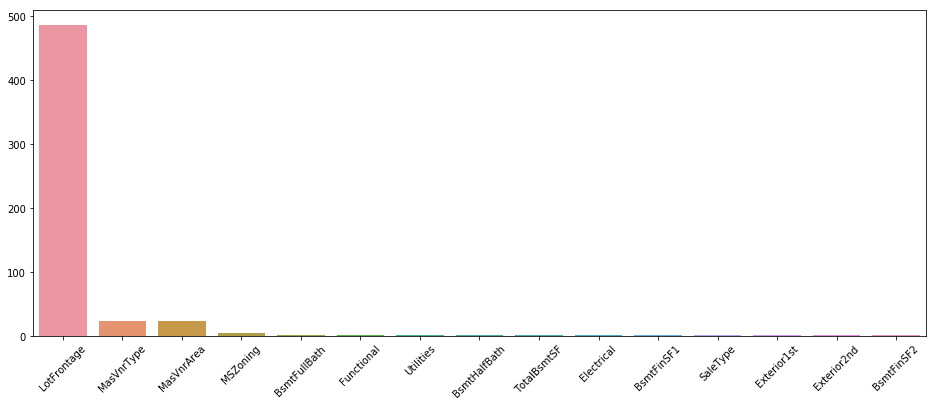

In [15]:
# Por motivos de representación sólo se mostrarán las 15 variables con mayor número de valores perdidos
sns.set_style()
plt.figure(figsize=(16,6))
plt.xticks(rotation=45)
ax = sns.barplot(x=var[:15], y=value[:15])

In [16]:
data ={"Var name": var, "Total":value, "Percent":percent}
con_na = pd.DataFrame(data, columns=[["Var name", "Total", "Percent"]])
con_na.head(25)

,Var name,Total,Percent
0,LotFrontage,486,16.649538
1,MasVnrType,24,0.822199
2,MasVnrArea,23,0.787941
3,MSZoning,4,0.137033
4,BsmtFullBath,2,0.068517
5,Functional,2,0.068517
6,Utilities,2,0.068517
7,BsmtHalfBath,2,0.068517
8,TotalBsmtSF,1,0.034258
9,Electrical,1,0.034258


Una vez actuado en consecuencia, se observa que solo existe una variable candidata a ser eliminada, **LotFrontage**. Por otro lado se ha pasado de tener 34 variables con valores perdidos a solamente 18. De estas 18 variables, 10 de ellas solo tienen 1 observación con valor faltante.

Las variables con mayor número de valores perdidos son **MasVnrType y MasVnrArea**, ambas asociadas a los materiales y área de albañileria.

Veamos si las variables con 1 solo dato faltante corresponden a la misma observación.

In [17]:
tmp = con_na[con_na["Total"]<4]["Var name"].tolist()

def NA_id(c):
    union.filter(col(c).isNull()).select('Id',c,'SalePrice').show()
    
for c in tmp:
    NA_id(c)

+----+------------+---------+
|  Id|BsmtFullBath|SalePrice|
+----+------------+---------+
|2121|        null|     null|
|2189|        null|     null|
+----+------------+---------+

+----+----------+---------+
|  Id|Functional|SalePrice|
+----+----------+---------+
|2217|      null|     null|
|2474|      null|     null|
+----+----------+---------+

+----+---------+---------+
|  Id|Utilities|SalePrice|
+----+---------+---------+
|1916|     null|     null|
|1946|     null|     null|
+----+---------+---------+

+----+------------+---------+
|  Id|BsmtHalfBath|SalePrice|
+----+------------+---------+
|2121|        null|     null|
|2189|        null|     null|
+----+------------+---------+

+----+-----------+---------+
|  Id|TotalBsmtSF|SalePrice|
+----+-----------+---------+
|2121|       null|     null|
+----+-----------+---------+

+----+----------+---------+
|  Id|Electrical|SalePrice|
+----+----------+---------+
|1380|      null|   167500|
+----+----------+---------+

+----+----------+--

Se observa que salvo la variable con id = 1380, el resto se encuentran en el conjunto de test, ya que **SalePrice** tiene el valor a "NULL", y no las podemos eliminar. Por lo que es necesario imputar los valores perdidos uno a uno dependiendo de la variable en cuestión.

## Imputación de valores perdidos

### Variables asociadas a Basement.

In [18]:
union.select(col('BsmtUnfSF')).describe().show()
union.select(col('TotalBsmtSF')).describe().show()

+-------+-----------------+
|summary|        BsmtUnfSF|
+-------+-----------------+
|  count|             2918|
|   mean|560.7721041809458|
| stddev|439.5436594234397|
|    min|                0|
|    max|             2336|
+-------+-----------------+

+-------+------------------+
|summary|       TotalBsmtSF|
+-------+------------------+
|  count|              2918|
|   mean|1051.7775873886224|
| stddev| 440.7662581159385|
|    min|                 0|
|    max|              6110|
+-------+------------------+



Con la inspección realizada anteriormente se observa que solo existen dos observaciones con valores missing para las variables asociadas a "Bsmnt", en concreto aquelllas con **Id** = 2121 y 2189. Dichos valores serán sustituidos por 0.

In [19]:
NA_dict={}
NA_dict['BsmtFinSF1']=0
NA_dict['BsmtFinSF2']=0
NA_dict['BsmtFullBath']=0
NA_dict['BsmtHalfBath']=0
NA_dict['BsmtUnfSF']=0
NA_dict['TotalBsmtSF']=0

### Variable electrical.

Solo existe una observación con este valor perdido por lo que se podría eliminar. Sin embargo, el tipo de instalación eléctrica puede guardar relación con el año de construcción de la vivienda. Por ello, se va localizar la observación con el valor perdido, así como su año de construcción.

In [20]:
union.filter(col('Electrical').isNull()).select('Id','Electrical','YearBuilt').show()

+----+----------+---------+
|  Id|Electrical|YearBuilt|
+----+----------+---------+
|1380|      null|     2006|
+----+----------+---------+



Como el año de construcción de la vivienda es 2006, vamos a hacer un filtrado a partir del año 2000 para ver cuál es la categoría dominante e imputamos el valor.

In [21]:
union.filter(union.YearBuilt > 2000).groupBy('Electrical').count().show()
NA_dict['Electrical']='SBrkr'

+----------+-----+
|Electrical|count|
+----------+-----+
|      null|    1|
|     SBrkr|  734|
+----------+-----+



### Variables asociadas al exterior

En este caso se procederá de manera equivalente al apartado anterior.

In [22]:
union.filter(col('Exterior1st').isNull()).select('Id','Electrical','YearBuilt', 'ExterQual', 'MasVnrType',
                                                'OverallQual').show()

+----+----------+---------+---------+----------+-----------+
|  Id|Electrical|YearBuilt|ExterQual|MasVnrType|OverallQual|
+----+----------+---------+---------+----------+-----------+
|2152|     SBrkr|     1940|       TA|      None|          5|
+----+----------+---------+---------+----------+-----------+



In [23]:
union.filter((union.YearBuilt < 1950) & (union.YearBuilt > 1930) & (union.ExterQual =='TA')\
             & (union.MasVnrType == "None") & (union.OverallQual == 5)).groupBy('Exterior1st').count().show()
union.filter((union.YearBuilt < 1950) & (union.YearBuilt > 1930) & (union.ExterQual =='TA')\
             & (union.MasVnrType == "None") & (union.OverallQual == 5)).groupBy('Exterior2nd').count().show()

+-----------+-----+
|Exterior1st|count|
+-----------+-----+
|       null|    1|
|    WdShing|    4|
|    Plywood|    4|
|    Wd Sdng|   31|
|    MetalSd|   28|
|    AsbShng|    1|
|    BrkComm|    1|
|    BrkFace|    2|
|    VinylSd|   13|
+-----------+-----+

+-----------+-----+
|Exterior2nd|count|
+-----------+-----+
|       null|    1|
|    HdBoard|    1|
|    Plywood|    4|
|    Wd Shng|    5|
|    Wd Sdng|   29|
|     Stucco|    1|
|    MetalSd|   29|
|    AsbShng|    1|
|    Brk Cmn|    1|
|    BrkFace|    1|
|    VinylSd|   12|
+-----------+-----+



Parece que las dos categorías más frecuentes son Wd Sdng y MetalSd. Se ha decidido probar la primera opción, ya que es mayoritaria en la primera considición y está empatada en la segunda.

In [24]:
NA_dict['Exterior1st']='Wd Sdng'
NA_dict['Exterior2nd']='Wd Sdng'

### Variables functional

In [25]:
union.filter(col('Functional').isNull()).select('Id','Functional','MSZoning', 'LotArea').show()

+----+----------+--------+-------+
|  Id|Functional|MSZoning|LotArea|
+----+----------+--------+-------+
|2217|      null|    null|  14584|
|2474|      null|      RM|  10320|
+----+----------+--------+-------+



In [26]:
union.filter((union.MSZoning == "RM") & (union.LotArea < 17500) & (union.LotArea > 7500))\
            .groupBy('Functional').count().show()

+----------+-----+
|Functional|count|
+----------+-----+
|      Maj1|    1|
|      null|    1|
|      Min2|    5|
|      Min1|    3|
|       Typ|  128|
|      Maj2|    3|
|       Mod|    4|
+----------+-----+



Parece razonable que la variable **Functional** esté relacionada con **MSZoning y LotArea**, ambas asociadas al uso del suelo y a su tamaño. Por tanto, se imputará la categoría Typ a ambos valores perdidos

In [27]:
NA_dict['Functional']='Typ'

### Variables Garage

In [28]:
union.filter(col('GarageArea').isNull()).select('Id','GarageCars','OverallQual', 'SalePrice', 'Neighborhood').show()
union.filter(col('GarageCars').isNull()).select('Id','GarageArea','OverallQual', 'SalePrice', 'Neighborhood').show()

+----+----------+-----------+---------+------------+
|  Id|GarageCars|OverallQual|SalePrice|Neighborhood|
+----+----------+-----------+---------+------------+
|2577|      null|          5|     null|      IDOTRR|
+----+----------+-----------+---------+------------+

+----+----------+-----------+---------+------------+
|  Id|GarageArea|OverallQual|SalePrice|Neighborhood|
+----+----------+-----------+---------+------------+
|2577|      null|          5|     null|      IDOTRR|
+----+----------+-----------+---------+------------+



Los valores perdidos en las variables de garage corresponden a la misma observación. Resulta complicado encontrar observaciones con características similares a que se está analizando, ya que la característica más correlada también está perdida. Se va a realizar un filtrado tanto por el tipo de vecindario como por una de las características más correladas, "OverallQual".

In [29]:
union.select('GarageArea').filter((union.Neighborhood == "IDOTRR") & (union.OverallQual < 7) & (union.OverallQual > 3))\
            .describe().show()
    
union.select('GarageCars').filter((union.Neighborhood == "IDOTRR") & (union.OverallQual < 7) & (union.OverallQual > 3))\
            .describe().show()

+-------+------------------+
|summary|        GarageArea|
+-------+------------------+
|  count|                76|
|   mean|310.19736842105266|
| stddev|208.42859814890036|
|    min|                 0|
|    max|               924|
+-------+------------------+

+-------+------------------+
|summary|        GarageCars|
+-------+------------------+
|  count|                76|
|   mean|1.0657894736842106|
| stddev|0.6600106325565667|
|    min|                 0|
|    max|                 2|
+-------+------------------+



In [30]:
union.filter((union.Neighborhood == "IDOTRR") & (union.OverallQual < 7) & (union.OverallQual > 3))\
            .groupBy('GarageCars').count().show()

+----------+-----+
|GarageCars|count|
+----------+-----+
|      null|    1|
|         1|   43|
|         2|   19|
|         0|   14|
+----------+-----+



Se observa que en el barrio hay viviendas con plazas de garage que van desde 0 a 2. Como es una variable importante para fijar el precio de la vivienda parece razonable que el valor perdido se deba a que no hay plaza de apacamiento para dicha vivienda, por lo que se le imputará el valor 0 en ambos casos.

In [31]:
NA_dict['GarageArea']=0
NA_dict['GarageCars']=0

### Variable KitchenQual

In [32]:
union.filter(col('KitchenQual').isNull()).select('Id','OverallQual','SalePrice','KitchenAbvGr','KitchenQual', \
                                                 'Neighborhood').show()

+----+-----------+---------+------------+-----------+------------+
|  Id|OverallQual|SalePrice|KitchenAbvGr|KitchenQual|Neighborhood|
+----+-----------+---------+------------+-----------+------------+
|1556|          5|     null|           1|       null|     ClearCr|
+----+-----------+---------+------------+-----------+------------+



In [33]:
union.filter((union.Neighborhood == "ClearCr") & (union.OverallQual ==5)\
                                   & (union.KitchenAbvGr == 1)).groupBy('KitchenQual').count().show()

+-----------+-----+
|KitchenQual|count|
+-----------+-----+
|         Gd|    1|
|       null|    1|
|         Ex|    2|
|         TA|    7|
+-----------+-----+



Sustituimos por el valor más común "TA"

In [34]:
NA_dict['KitchenQual'] = 'TA'

### Variable MSZoning

In [35]:
union.filter(col('MSZoning').isNull()).select('Id','OverallQual','MSZoning','Functional','LotArea', \
                                                 'Neighborhood').show()

+----+-----------+--------+----------+-------+------------+
|  Id|OverallQual|MSZoning|Functional|LotArea|Neighborhood|
+----+-----------+--------+----------+-------+------------+
|1916|          2|    null|      Min1|  21780|      IDOTRR|
|2217|          1|    null|      null|  14584|      IDOTRR|
|2251|          5|    null|      Maj1|  56600|      IDOTRR|
|2905|          1|    null|       Mod|  31250|     Mitchel|
+----+-----------+--------+----------+-------+------------+



In [36]:
union.filter((union.OverallQual < 5)).groupBy('MSZoning').count().show()

+--------+-----+
|MSZoning|count|
+--------+-----+
| C (all)|   20|
|    null|    3|
|      RH|    4|
|      RL|  164|
|      RM|   92|
+--------+-----+



Se imputará el valor mas frecuente : "RL"

In [37]:
NA_dict['MSZoning'] = 'RL'

### Variable MasVnrArea

Esta variable indica los metros cuadrados de revestimiento (madera, enchapado, mármol) de la vivienda. Vamos a buscar características comunes de las viviendas con dicho valor faltante y realizaremos un estudio estadístico de las observaciones con características similares.

In [38]:
union.filter(col('MasVnrArea').isNull()).select('Id','OverallQual','MSZoning','SalePrice','MasVnrType','Neighborhood')\
.show()

+----+-----------+--------+---------+----------+------------+
|  Id|OverallQual|MSZoning|SalePrice|MasVnrType|Neighborhood|
+----+-----------+--------+---------+----------+------------+
| 235|          6|      RL|   216500|      null|     Gilbert|
| 530|          6|      RL|   200624|      null|     Crawfor|
| 651|          7|      FV|   205950|      null|     Somerst|
| 937|          7|      RL|   184900|      null|     SawyerW|
| 974|          7|      FV|   182000|      null|     Somerst|
| 978|          7|      FV|   199900|      null|     Somerst|
|1244|         10|      RL|   465000|      null|     NridgHt|
|1279|          8|      RL|   237000|      null|     CollgCr|
|1692|          8|      RL|     null|      null|     Gilbert|
|1707|          7|      FV|     null|      null|     Somerst|
|1883|          7|      RL|     null|      null|     CollgCr|
|1993|          7|      RL|     null|      null|     Gilbert|
|2005|          8|      RL|     null|      null|     Somerst|
|2042|  

In [39]:
union.select('MasVnrArea').filter((union.OverallQual > 6) &((union.MSZoning == "RL")|(union.MSZoning == "FV")))\
                          .describe().show()

+-------+------------------+
|summary|        MasVnrArea|
+-------+------------------+
|  count|               995|
|   mean|179.54371859296484|
| stddev|227.73285747666753|
|    min|                 0|
|    max|              1600|
+-------+------------------+



Parece razonable imputar el valor 0 a esta variable. La media se acerca más al valor mínimo (0) que el máximo (1600). Además tiene mas sentido que la ausencia del dato pretenda indicar que no hay ningún tipo de revestimiento. De hecho, la variable MasVnrType que indica el tipo de revestimiento también falta en todas las observaciones, lo que corrobora la teoría planteada.

In [40]:
NA_dict['MasVnrArea'] = 0
NA_dict['MasVnrType'] = 0

### Variable SaleType

In [41]:
union.filter(col('SaleType').isNull()).select('Id','OverallQual','MSZoning','SalePrice','LotArea','Neighborhood')\
.show()

+----+-----------+--------+---------+-------+------------+
|  Id|OverallQual|MSZoning|SalePrice|LotArea|Neighborhood|
+----+-----------+--------+---------+-------+------------+
|2490|          5|      RL|     null|  13770|      Sawyer|
+----+-----------+--------+---------+-------+------------+



In [42]:
union.filter((union.Neighborhood == "Sawyer") & (union.OverallQual == 5)\
                                   & (union.MSZoning == 'RL')).groupBy('SaleType').count().show()

+--------+-----+
|SaleType|count|
+--------+-----+
|     COD|    2|
|    null|    1|
|     Oth|    1|
|      WD|  106|
+--------+-----+



El valor más frecuente en viviendas con características similares es "WD"

In [43]:
NA_dict['SaleType'] = "WD"

### Variable Utilities

In [44]:
union.filter(col('Utilities').isNull()).select('Id','OverallQual','OverallCond','HouseStyle','Neighborhood',\
                                               'HeatingQC','Electrical','YearBuilt','YearRemodAdd').show()

+----+-----------+-----------+----------+------------+---------+----------+---------+------------+
|  Id|OverallQual|OverallCond|HouseStyle|Neighborhood|HeatingQC|Electrical|YearBuilt|YearRemodAdd|
+----+-----------+-----------+----------+------------+---------+----------+---------+------------+
|1916|          2|          4|    1Story|      IDOTRR|       TA|     FuseA|     1910|        1950|
|1946|          6|          2|    1Story|     Gilbert|       TA|     FuseA|     1952|        1952|
+----+-----------+-----------+----------+------------+---------+----------+---------+------------+



Con una rápida inspección nos damos cuenta de que se trata de casas antiguas que no han sido remodeladas a partir de los 50. La instalación eléctrica es antigua y tienen sistema de refrigeración y calefacción típicos. La calidad general de la casa es media-baja y no están en buen estado. Vamos a buscar casas con características similares.

In [45]:
union.filter((union.HeatingQC == "TA") & (union.Electrical == "FuseA") & (union.OverallQual < 7)\
                                 & (union.OverallCond < 6) & (union.HouseStyle == "1Story") & \
                                 (union.YearRemodAdd < 1970)).groupBy('Utilities').count().show()

+---------+-----+
|Utilities|count|
+---------+-----+
|     null|    2|
|   AllPub|   24|
+---------+-----+



Por los datos recogidos en el análisis se ha decidido imputar el valor de 'AllPub'. Sin embargo, se ha realizado un estudio demasiado exhaustivo de esta variable, dejando de lado la posibilidad de que no aporte información desde un punto de vista más amplio. Para ello, se va a analizar los diferentes valores que toma en todo el conjunto de datos.

In [46]:
union.groupBy(col('Utilities')).count().show()

+---------+-----+
|Utilities|count|
+---------+-----+
|     null|    2|
|   NoSeWa|    1|
|   AllPub| 2916|
+---------+-----+



Se comprueba que la variable Utilities no aporta ninguna información, y junto con la variable LotFrontage van a ser eliminadas.

## Eliminación de variables e imputación de valores perdidos.

In [47]:
# Eliminamos las variables comentadas

union = union.drop('Utilities', 'LotFrontage')

In [48]:
# Imputamos los valores perdidos

union = union.fillna(NA_dict)

In [49]:
# Comprobación de que no existen valores perdidos
# El resultado se convierte a diccionario para facilitar el tratamiento
dic_list = tmp1(union)[0].asDict()

# Se filtran aquellas variables sin valores perdidos
dic_filtered = dict((k, v) for (k, v) in dic_list.items() if v > 0)

In [50]:
# La única variable con valores missing es "SalePrice", generados a propósito para discriminar el conjunto test
dic_filtered

{'SalePrice': 1459}

## Transformaciones de variables

Como ya se introdujo en el notebook anterior, se va a proceder a aplicar una transformación logarítmica a aquellas variables que no siguen una distribución normal.

In [51]:
log_list=['GrLivArea','GarageArea','1stFlrSF', 'TotalBsmtSF', 'SalePrice']

for c in log_list:
    union = union.withColumn(c,log1p(union[c]))

## Guardado de datos

In [63]:
path = 'preprocessed'
union.write.csv(path, header=True, mode='overwrite')

In [ ]:
spark.stop()